$\mathbf{LABORATORIUM~NR~8~-~Przycinanie~drzew~decyzyjnych,~lasy~losowe,~miary~jakości~klasyfikatorów}$

Na tych zajęciach ponownie analizować będziemy drzewa decyzyjne, lecz tym razem poznamy metodę pruningu, czyli przycinania drzewa. Zabieg ten ma wyeliminować potencjalny overfitting. W dalszej części wyuczymy las losowy, jedną z najlepszych metod uczenia nadzorowanego, a także poznamy metody oceny jakości klasyfikatorów.
$\mathbf{UWAGA!}$ Do dzisiejszych zajęć potrzebna jest biblioteka scikit-learn w wersji co najmniej 0.22!

Będziemy dziś pracować na zbiorze danych Breast Cancer Wisconsin, czyli zbiorze danych dotyczącym nowotworu piersi. Na podstawie 30 argumentów algorytm ma zdecydować, czy dany przypadek jest łagodny, czy złośliwy (mamy zatem do czynienia z klasyfikacją binarną). Szczegółowy opis zbioru danych znajduje się tutaj: https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

Wczytamy teraz zbiór danych, nauczymy drzewo decyzyjne, a ponadto wyliczymy wartości współczynnika alpha. Im większa jego wartość, tym więcej węzłów zostanie wyciętych z drzewa. Zwiększa to jednak zanieczyszczenie liści drzewa. Postaramy się zobaczyć, jak przycinanie drzewa wpływa na dokładność klasyfikacji dla zbioru treningowego oraz testowego.

In [62]:
X, y = load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=2)
classifier = tree.DecisionTreeClassifier(random_state=0)
classifier.fit(X_train, y_train)
path = classifier.cost_complexity_pruning_path(X_train,
                                               y_train)
# path zwraca kolejne wartości współczynnika alpha oraz łączne "zanieczyszczenie" wszystkich liści drzewa
# odpowiadające danej wartości współczynnika. Im bardziej przycięte drzewo, tym większa nieczystość liści.
print(path)
alphas = path.ccp_alphas

{'ccp_alphas': array([0.        , 0.00232818, 0.0068506 , 0.00730308, 0.00985915,
       0.01533646, 0.02221077, 0.02346023, 0.02771098, 0.33529903]), 'impurities': array([0.        , 0.00931271, 0.0230139 , 0.03031698, 0.04017613,
       0.0555126 , 0.07772337, 0.1011836 , 0.12889458, 0.46419361])}


Przekonajmy się, jak wygląda drzewo decyzyjne przed dokonaniem pruningu.

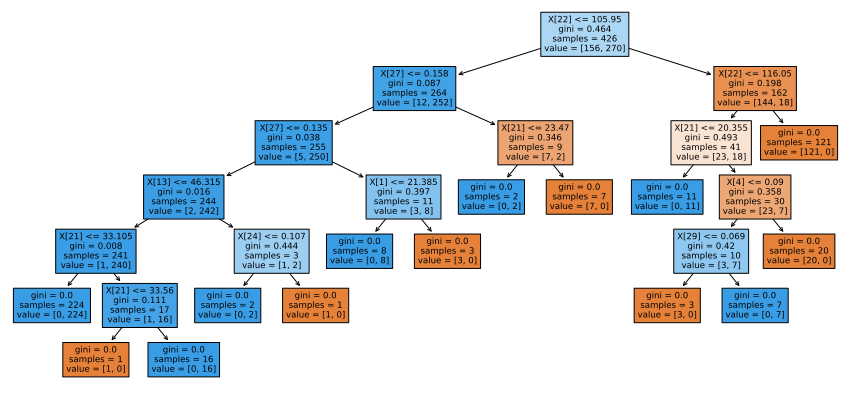

In [63]:
%config InlineBackend.figure_format = 'svg'
plt.figure(figsize=(15, 7))
tree.plot_tree(classifier, filled=True)
plt.show()

Teraz będziemy stopniowo przycinać drzewo decyzyjne zgodnie z wartościami współczynnika alpha.

In [64]:
classifiers = []
for alpha in alphas:
    classifier = tree.DecisionTreeClassifier(random_state=0,
                                             ccp_alpha=alpha)
    classifier.fit(X_train, y_train)
    classifiers.append(classifier)

Sprawdzimy teraz dokładność klasyfikacji na zbiorze treningowym i testowym dla różnych wygenerowanych drzew.

In [65]:
train_scores = [clf.score(X_train, y_train) for clf in classifiers]
test_scores = [clf.score(X_test, y_test) for clf in classifiers]

 Na koniec usuwamy trywialny przypadek, gdy zostałby nam tylko jeden wierzchołek.

In [66]:
classifiers = classifiers[:-1]
alphas = alphas[:-1]

Zobaczmy teraz wykres wartości współczynnika alpha w zestawieniu z dokładnością klasyfikacji dla przyciętego drzewa odpowiadającego tej wartości współczynnika. Bierzemy wszystkie wartości wektora train_scores oraz test_scores, za wyjątkiem ostatniej (bez trywialnego przypadku).

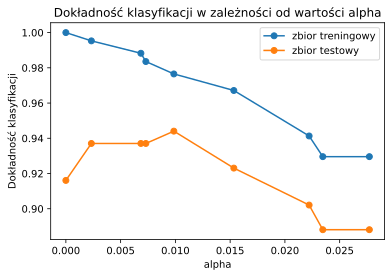

In [67]:
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("Dokładność klasyfikacji")
ax.set_title("Dokładność klasyfikacji w zależności od wartości alpha")
ax.plot(alphas, train_scores[:-1], marker='o', label="zbior treningowy")
ax.plot(alphas, test_scores[:-1], marker='o', label="zbior testowy")
ax.legend()
plt.show()

Skomentujmy teraz otrzymane wyniki. Najlepszą dokładność na zbiorze treningowym otrzymujemy dla wyjściowego, pełnego drzewa. Wraz ze stopniowym przycinaniem drzewa, maleje nam dokładność na zbiorze treningowym, a rośnie na testowym, co oznacza, że mieliśmy do czynienia z overfittingiem. Najlepszą wartość na zbiorze testowym (ok. 94%) otrzymujemy dla alpha=0.01. To drzewo wydaje się być drzewem optymalnym. Od tego momentu maleć zaczyna nam zarówno dokładność klasyfikacji na zbiorze treningowym jak i testowym, co oznacza, że dalsze przycinanie drzewa nie ma sensu.

Zobaczmy, jak wygląda drzewo, które uznaliśmy za optymalne.

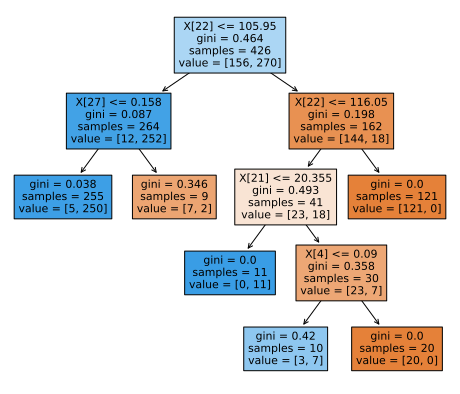

In [68]:
plt.figure(figsize=(8, 7))
tree.plot_tree(classifiers[4], filled=True)
plt.show()

$\mathbf{Lasy~losowe}$

Teraz przejdziemy do algorytmu lasów losowych (ang. random forest). Wyobraźmy sobie, że zestaw uczący składa się np. z 10000 próbek. Podzielmy teraz dane na 100 zestawów, gdzie w każdym zestawie będzie znajdowało się 100 przykładów uczących. Możemy teraz wytrenować po jednym drzewie decyzyjnym dla każdego zestawu danych. A w jaki sposób podejmowana będzie ostateczna decyzja dla nowych przykładów? Niech każde z wytrenowanych drzew dokona na nich klasyfikacji (ograniczmy się do klasyfikacji binarnej: klasa 0 lub 1). Zapewne stało się tak, że część drzew wybrała dla danej próbki klasę 0, a inna część klasę 1. Co zatem wybieramy? Wybieramy tę klasę, która została wskazana najczęściej; taką, którą wskazała większość wytrenowanych drzew (czyli dokonujemy prognozy metodą głosowania większościowego). Sugerujemy się zatem modą (dominantą). Tak działa algorytm lasów losowych.

Co do wyboru podzbiorów danych uczących, nie muszą być one rozłączne. Możemy dokonywać próbkowania ze zwracaniem (ang. bagging, bootstrap aggregation), czyli np. za każdym razem wybieramy podzbiór 100 danych spośród 1000 dostępnych, ale przy kolejnych drzewach z niezerowym prawdopodobieństwem każda próbka może ponownie znaleźć się pośród danych uczących.

Sprawdźmy teraz, jak algorytm lasu losowego spisze się na analizowanym przez nas przed chwilą zbiorze danych dot. zachorowań na raka. Parametr n_estimators określa liczbę drzew w lesie losowym, parametr max_leaf_nodes określa maksymalną liczbę liści, zaś n_jobs pozwala na zrównoleglenie obliczeń. Jeżeli jest ustawiony na -1, to wykorzystuje wszystkie dostępne w naszym komputerze CPU, z kolei ustawienie na 1 zabrania użycia wielowątkowości.

In [69]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=200, max_leaf_nodes=15, n_jobs=-1, random_state=0)
forest.fit(X_train, y_train)

RandomForestClassifier(max_leaf_nodes=15, n_estimators=200, n_jobs=-1,
                       random_state=0)

In [70]:
forest_train_score = forest.score(X_train, y_train)
forest_test_score = forest.score(X_test, y_test)
print("Dokladnosc klasyfikacji lasu losowego na zbiorze treningowym wynosi {0:3f}, \
zas na zbiorze testowym {1:3f}".format(forest_train_score,
                                       forest_test_score))

Dokladnosc klasyfikacji lasu losowego na zbiorze treningowym wynosi 0.995305, zas na zbiorze testowym 0.951049


Poprawiliśmy zatem dokładność klasyfikacji. Przy zachowaniu ponad 99% dokładności na zbiorze treningowym, udało się uzyskać ponad 95% dokładności na zbiorze testowym. To znacznie lepszy wynik niż w przypadku pojedynczego drzewa decyzyjnego, nawet optymalnie przyciętego.

Spróbujmy się teraz dowiedzieć, które cechy (spośród 30 dostępnych) miały największy wpływ na podjęcie decyzji przez algorytm lasów losowych.

In [71]:
number = np.arange(0, 31, 1)
for number, score in zip(number, forest.feature_importances_):
    print(f'Cecha nr {number + 1}, istotność: {score:.3f}')
print('Posortowane cechy od najmniej do najbardziej istotnej')
print(np.argsort(forest.feature_importances_) + 1)
print(f'Pięć najbardziej istotnych cech ma łączny wpływ {np.sum(np.sort(forest.feature_importances_)[-5:]) * 100.:.3f} \
% na podjęcie decyzji.')

Cecha nr 1, istotność: 0.033
Cecha nr 2, istotność: 0.014
Cecha nr 3, istotność: 0.053
Cecha nr 4, istotność: 0.048
Cecha nr 5, istotność: 0.007
Cecha nr 6, istotność: 0.007
Cecha nr 7, istotność: 0.050
Cecha nr 8, istotność: 0.103
Cecha nr 9, istotność: 0.002
Cecha nr 10, istotność: 0.004
Cecha nr 11, istotność: 0.018
Cecha nr 12, istotność: 0.004
Cecha nr 13, istotność: 0.015
Cecha nr 14, istotność: 0.044
Cecha nr 15, istotność: 0.002
Cecha nr 16, istotność: 0.002
Cecha nr 17, istotność: 0.003
Cecha nr 18, istotność: 0.005
Cecha nr 19, istotność: 0.003
Cecha nr 20, istotność: 0.003
Cecha nr 21, istotność: 0.134
Cecha nr 22, istotność: 0.012
Cecha nr 23, istotność: 0.135
Cecha nr 24, istotność: 0.109
Cecha nr 25, istotność: 0.011
Cecha nr 26, istotność: 0.012
Cecha nr 27, istotność: 0.029
Cecha nr 28, istotność: 0.121
Cecha nr 29, istotność: 0.007
Cecha nr 30, istotność: 0.008
Posortowane cechy od najmniej do najbardziej istotnej
[ 9 16 15 19 17 20 12 10 18  6 29  5 30 25 22 26  2 13 

Widzimy zatem, że dominujący wpływ na wybory lasu miały cechy nr 23, 21, 28, 34 i 8. Tylko te 5 cech spośród 30 dostępnych ma łącznie ok. 60% wpływu na podejmowanie decyzji o przynależności do danej klasy. Można wykorzystywać te algorytmy do wyboru istotnych cech spośród wielu dostępnych.

$ \mathbf{Miary~jakości~klasyfikatora} $

Dokonamy teraz oceny jakości klasyfikatora. Na początku wywołamy znaną nam z poprzednich zajęć macierz pomyłek (ang. confusion matrix). Dodatkowy argument labels oznacza, że chcemy mieć w pierwszym wierszu informacje dotyczące przykładów związanych z pierwszą klasą, w drugim zaś wierszu z zerową.
Wiersze w macierzy pomyłek oznaczają rzeczywiste klasy, a kolumny przewidywane

In [72]:
forest_prediction = forest.predict(X_test)
cf_matrix = confusion_matrix(y_test, forest_prediction, labels=[1, 0])
print(cf_matrix)

[[83  4]
 [ 3 53]]


W zbiorze testowym znajdują się 143 przypadki: 87 z nich należy do klasy 1, zaś 56 do klasy 0. Las losowy dokonał prawidłowej klasyfikacji 83 przypadków należących do klasy 1 (odsetek prawdziwie pozytywnych, True Positive, TP), zaś 4 przypadki zostały niesłusznie uznane za klasę 0 (odsetek fałszywie negatywnych, False Negative, FN). 53 przypadki klasy 0 zostały faktycznie uznane za klasę 0 (odsetek prawdziwie negatywnych, True Negatives, TN), z kolei 3 przypadki klasy 0 zostały przydzielone przez klasyfikator do klasy 1 (odsetek fałszywie pozytywnych, False Positives, FP).

Przyjrzyjmy się teraz dwóm miarom jakości klasyfikatorów wyrażającym dokładność pozytywnych prognoz: precyzji (ang. precision) oraz pełności (ang. sensitivity).

$ precision = \dfrac{TP}{TP + FP} \\ $

$ recall = \dfrac{TP}{TP + FN}$

Polecam opracowanie angielskiej Wikipedii: https://en.wikipedia.org/wiki/Precision_and_recall

In [73]:
from sklearn.metrics import precision_score, recall_score
precision = precision_score(y_test, forest_prediction)
recall = recall_score(y_test, forest_prediction)
print("Precyzja wynosi {0:3f}, zas pelnosc {1:3f}".format(precision, recall))

Precyzja wynosi 0.965116, zas pelnosc 0.954023


$precision = \dfrac{83}{83 + 3}$

$recall = \dfrac{83}{83 + 4}$

Na koniec przyjrzyjmy się krzywej ROC, czyli charakterystyce roboczej odbiornika (ang. receiver operating characteristic curve). Wyraża ona jakość klasyfikatora binarnego poprzez wykres pełności (stosunku dobrze wyznaczonych prawidziwie pozytywnych przykładów $-$ True Positives $-$ do rzeczywistej liczby pozytywnych przypadków, czyli True Positives + False Negatives, TPR, True Positive Rate) w odniesieniu do FPR, czyli False Positive Rate (ilorazu fałszywie pozytywnych przykładów do sumy fałszywie pozytywnych i prawdziwie negatywnych). Mówiąc w uproszczeniu, im bardziej krzywa szybciej zbiega do jedynki, tym lepiej. Linią przerywaną zaznaczony jest całkowicie losowy klasyfikator (o dokładności klasyfikacji 50%).

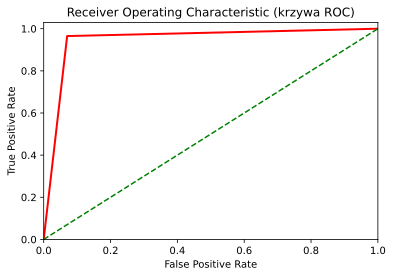

In [74]:
from sklearn.metrics import roc_curve

FPR, TPR, _ = roc_curve(forest_prediction, y_test)
plt.plot(FPR, TPR, linewidth=2, color='red') # wykres krzywej ROC
plt.plot([0, 1], [0, 1], color='green', linestyle='--') # wykres linii przerywanej
plt.xlim([0.0, 1.0]) # zakres na osi OX
plt.ylim([0.0, 1.03]) # zakres na osi OY, minimalnie ponad 1
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (krzywa ROC)')
plt.show()

Obliczmy teraz pole pod krzywą ROC, czyli wartość AUC (area under curve). W idealnym przypadku wynosiłaby ona 1, zaś dla losowego klasyfikatora jest to 0.5

In [75]:
from sklearn.metrics import roc_auc_score

AUC = roc_auc_score(forest_prediction, y_test)
print(AUC)

0.9474704202366381


Otrzymany wynik, czyli niespełna 0.95, jest bardzo dobrym rezultatem dla klasyfikatora. 

$ \mathbf{Zadanie:} $ Skorzystać ze zbioru danych logistyczna.csv udostępnionego na Platformie przy temacie dotyczącym regresji logistycznej. Za każdym razem używać argumentu random_state=0 (przy podziale zbioru oraz przy nauczaniu klasyfikatorów). Podzielić dane na zbiór treningowy i testowy w stosunku 60%/40%. Wyuczyć klasyfikator lasu losowego. Porównać otrzymane wyniki accuracy na zbiorze treningowym i testowym. Dla predykcji na zbiorze testowym wyznaczyć confusion matrix oraz wykreślić na jednym rysunku krzywą ROC dla obydwu klasyfikatorów. Wyliczyć wartość AUC.

Bibliografia: na podstawie dokumentacji biblioteki Scikit-Learn, książki A. Gerona "Uczenie maszynowe z użyciem Scikit-Learn i TensorFlow" oraz Wikipedii